In [1]:
from joblib import dump
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Import libraries
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:

df_group5 = pd.read_csv('../cleaned_data_KSI.csv')
df_group5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17665 entries, 0 to 17664
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LATITUDE       17665 non-null  float64
 1   LONGITUDE      17665 non-null  float64
 2   ACCLOC         12585 non-null  object 
 3   VISIBILITY     17665 non-null  object 
 4   LIGHT          17665 non-null  object 
 5   RDSFCOND       17665 non-null  object 
 6   ACCLASS        17665 non-null  object 
 7   IMPACTYPE      17665 non-null  object 
 8   INVTYPE        17665 non-null  object 
 9   INVAGE         17665 non-null  object 
 10  INJURY         9340 non-null   object 
 11  DRIVCOND       9007 non-null   object 
 12  PEDESTRIAN     17665 non-null  int64  
 13  CYCLIST        17665 non-null  int64  
 14  AUTOMOBILE     17665 non-null  int64  
 15  MOTORCYCLE     17665 non-null  int64  
 16  TRUCK          17665 non-null  int64  
 17  TRSN_CITY_VEH  17665 non-null  int64  
 18  EMERG_

In [3]:
print(df_group5.describe().T)

                 count       mean       std        min        25%        50%  \
LATITUDE       17665.0  43.711492  0.056172  43.589678  43.662445  43.704245   
LONGITUDE      17665.0 -79.395495  0.104719 -79.638390 -79.469287 -79.396632   
PEDESTRIAN     17665.0   0.410643  0.491964   0.000000   0.000000   0.000000   
CYCLIST        17665.0   0.107614  0.309901   0.000000   0.000000   0.000000   
AUTOMOBILE     17665.0   0.909086  0.287495   0.000000   1.000000   1.000000   
MOTORCYCLE     17665.0   0.086499  0.281107   0.000000   0.000000   0.000000   
TRUCK          17665.0   0.061308  0.239901   0.000000   0.000000   0.000000   
TRSN_CITY_VEH  17665.0   0.062157  0.241447   0.000000   0.000000   0.000000   
EMERG_VEH      17665.0   0.002434  0.049279   0.000000   0.000000   0.000000   
SPEEDING       17665.0   0.138070  0.344983   0.000000   0.000000   0.000000   
AG_DRIV        17665.0   0.521483  0.499552   0.000000   0.000000   1.000000   
REDLIGHT       17665.0   0.086046  0.280

In [4]:

x_group5 = df_group5.drop(columns=['ACCLASS'], axis=1)
y_group5 = df_group5['ACCLASS']


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(x_group5, y_group5):
    x_train, x_test = x_group5.loc[train_index], x_group5.loc[test_index]
    y_train, y_test = y_group5.loc[train_index], y_group5.loc[test_index]

In [5]:

print("Before using SMOTE")
print(y_train.value_counts())

Before using SMOTE
ACCLASS
Non-Fatal Injury    10651
Fatal                1714
Name: count, dtype: int64


In [6]:

numerical_cols = x_train.select_dtypes(include=np.number).columns
cat_cols = x_train.select_dtypes(include='object').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, cat_cols)
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

x_train_prepared = dt_pipeline.fit_transform(x_train)

x_train_prepared, y_train = SMOTE(
    random_state=42).fit_resample(x_train_prepared, y_train)

In [7]:

# Print class distribution after SMOTE
print("After using SMOTE")
print(y_train.value_counts())
print()

After using SMOTE
ACCLASS
Fatal               10651
Non-Fatal Injury    10651
Name: count, dtype: int64



In [8]:


dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train_prepared, y_train)

DecisionTreeClassifier(random_state=42)

In [9]:
from sklearn.model_selection import KFold, cross_val_score

crossvalscore = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(dt, x_train_prepared, y_train,
                         cv=crossvalscore, scoring='accuracy')
print("Cross validation scores for 10 folds: ", scores)
print("Mean cross validation score: ", scores.mean())

Cross validation scores for 10 folds:  [0.93007977 0.91647114 0.91220657 0.91455399 0.93286385 0.92112676
 0.92957746 0.93380282 0.92018779 0.92441315]
Mean cross validation score:  0.923528330942955


In [10]:

y_pred = dt.predict(x_train_prepared)
print("Accuracy score on training data: ", accuracy_score(y_train, y_pred))

Accuracy score on training data:  1.0


In [11]:

x_test_transformed = dt_pipeline.transform(x_test)
y_pred = dt.predict(x_test_transformed)
print("Accuracy score on testing data: ", accuracy_score(y_test, y_pred))

Accuracy score on testing data:  0.880943396226415


[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


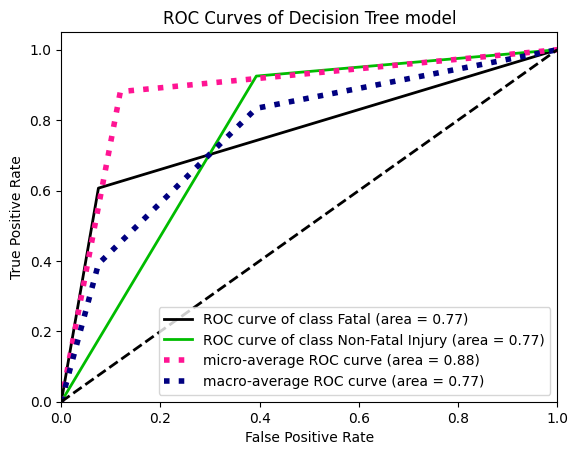

In [12]:

y_probas = dt.predict_proba(x_test_transformed)
print(y_probas)
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('ROC Curves of Decision Tree model')
plt.show()

In [13]:

report = classification_report(y_test, y_pred)
print("Classification report of Decision Tree before tuning model")
print(report)

Classification report of Decision Tree before tuning model
                  precision    recall  f1-score   support

           Fatal       0.57      0.61      0.59       735
Non-Fatal Injury       0.94      0.93      0.93      4565

        accuracy                           0.88      5300
       macro avg       0.75      0.77      0.76      5300
    weighted avg       0.88      0.88      0.88      5300



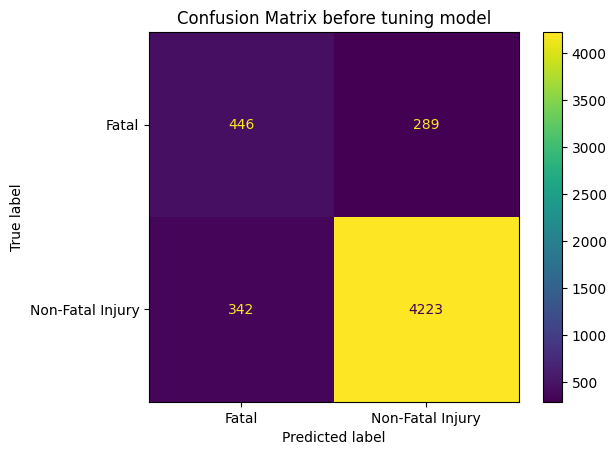

In [14]:
cfs_matrix = confusion_matrix(y_test, y_pred, labels=dt.classes_)
display = ConfusionMatrixDisplay(cfs_matrix, display_labels=dt.classes_)
display.plot()
plt.title("Confusion Matrix before tuning model")
plt.show()

In [15]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid.fit(x_train_prepared, y_train)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
270 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
218 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packag

Best parameters:  {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score:  0.9077587971700971
Best estimator:  DecisionTreeClassifier(max_depth=40, max_features='sqrt', random_state=42)


In [16]:

dt_best = grid.best_estimator_
dt_best.fit(x_train_prepared, y_train)
y_pred = dt_best.predict(x_test_transformed)
print("Accuracy score on testing data with best parameters: ",
      accuracy_score(y_test, y_pred))

Accuracy score on testing data with best parameters:  0.8666037735849057


In [17]:

report = classification_report(y_test, y_pred)
print("Classification report of Decision Tree after tuning model")
print(report)

Classification report of Decision Tree after tuning model
                  precision    recall  f1-score   support

           Fatal       0.52      0.54      0.53       735
Non-Fatal Injury       0.93      0.92      0.92      4565

        accuracy                           0.87      5300
       macro avg       0.72      0.73      0.73      5300
    weighted avg       0.87      0.87      0.87      5300



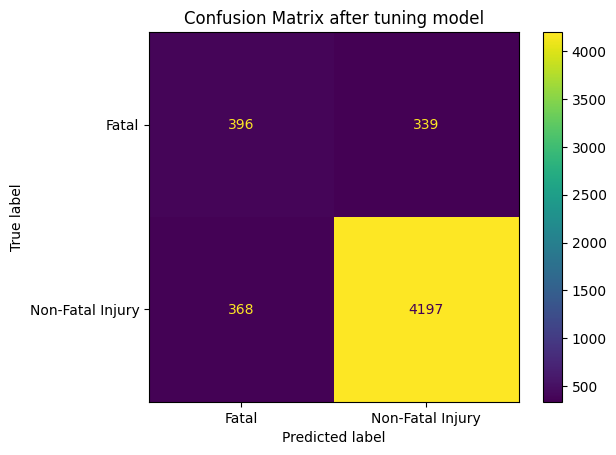

In [18]:

cfs_matrix = confusion_matrix(y_test, y_pred, labels=dt.classes_)
display = ConfusionMatrixDisplay(cfs_matrix, display_labels=dt.classes_)
display.plot()
plt.title("Confusion Matrix after tuning model")
plt.show()

In [20]:

dump(dt_best, '../deployment/dt_model.pkl')

['../deployment/dt_model.pkl']